In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

# constants
pca_components = 8  # I used 8 for a dataset with 14 features

In [61]:
df = pd.read_csv("ml_models_dataset_with_zone.csv", index_col='timestamp')
df.head()

,cell_name,ho_failure_rate,num_voice_attempts,voice_drop_rate,num_data_attempts,voice_setup_failure_rate,voice_tot_failure_rate,avail_period_duration,bandwidth,throughput_rate,...,tech_freq_W,tech_freq_X,tech_freq_Y,tech_freq_Z,zone_-1,zone_0,zone_1,zone_2,zone_3,zone_4
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-11-04 00:00:00+00:00,22_21Q,0.000679,0.000679,0.000679,0.000679,0.000679,0.000679,1.0,0.09955,6.786382e-04,...,0,0,0,0,0,0,1,0,0,0
2019-11-04 00:00:00+00:00,02_31Q,0.006013,0.000000,0.006013,0.000781,0.006013,0.006013,1.0,0.09955,2.322707e-08,...,0,0,0,0,0,0,0,1,0,0
2019-11-04 00:00:00+00:00,25_11W,0.001574,0.001574,0.001574,0.001574,0.001574,0.001574,1.0,1.00000,1.573807e-03,...,1,0,0,0,0,0,1,0,0,0
2019-11-04 00:00:00+00:00,28_11Y,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.00000,0.000000e+00,...,0,0,1,0,0,0,0,1,0,0
2019-11-04 00:00:00+00:00,12_21W,0.001032,0.013902,0.000000,0.091727,0.000000,0.000000,1.0,1.00000,5.298183e-04,...,1,0,0,0,0,0,1,0,0,0


In [62]:
# Help functions

def get_cell_df(cell_name):
  return df[df['cell_name'] == cell_name]

def add_aggregated_time_information(data, window_size=5):
  time = np.zeros(shape=data.shape)
  for i in range(window_size, time.shape[0]):
    time[i] = np.mean(data[i-window_size:i], axis=0)

  return np.concatenate((data, time), axis=1)

In [63]:
def getIsolationForestScore(df, pca_components):
    """
    df: pandas dataframe, preprocessed (only numerical values)
    pca_components: int, number of components to reduce to with pca

    returns: list of floats, score for each example in df
    """
    pca = PCA(n_components=pca_components)
    data = pca.fit_transform(df)
    data = add_aggregated_time_information(data)
    model =  IsolationForest(contamination = 0.1, random_state=42)
    model.fit(data)
    return model.score_samples(data)

def runIsolationForestForAllCells(df, pca_components):
    """
    df: pandas dataframe, index: timestamp - cell_name must be included - preprocessed
    """
    scores_per_cell = {}
    #df['anom_scores'] = np.zeros(df.shape[0])
    for i, cell in enumerate(df['cell_name'].unique()):
        # Hardcode dropping of cells with very little variation
        if cell == '29_11Q':
            continue
        if cell == '28_21Y':
            continue
        
        # Get df with only the current cell_name-rows
        df_temp = get_cell_df(cell)
        df_temp = df_temp.drop(columns='cell_name')
        # Reduce dimentions, fit iForest
        scores = getIsolationForestScore(df_temp, pca_components)
        # Add scores to original df
        #df.loc[df['cell_name'] == cell, 'anom_scores'] = scores
        scores_per_cell[cell] = {'score': scores, 'timestep':df_temp.index} # Low = abnormal
        
        if i%50 == 0:
            print('.... done with:', i)
    return scores_per_cell

In [64]:
#df_with_scores = runIsolationForestForAllCells(df, pca_components)
scores_per_cell = runIsolationForestForAllCells(df, pca_components)

.... done with: 0
.... done with: 50
.... done with: 100
.... done with: 150
.... done with: 200
.... done with: 250
.... done with: 300
.... done with: 350
.... done with: 400


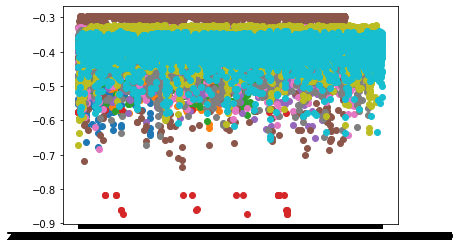

In [66]:
#cell_names_to_plot = ['00_11Z', '22_21Q', '13_21X'] # Not 29_11Q or 28_21Y
cell_name_to_plot = df['cell_name'].unique()

cell_names_to_plots = [cell for cell in cell_name_to_plot if cell != '29_11Q']
cell_names_to_plots2 = [cell for cell in cell_names_to_plots if cell != '28_21Y']

for cell_to_plot in cell_names_to_plots2[:10]:
    
  plt.scatter(scores_per_cell[cell_to_plot]['timestep'], scores_per_cell[cell_to_plot]['score'])

plt.show()

In [70]:
import json

for key, val in scores_per_cell.items():
    val['score'] = list(val['score'])
    


In [72]:
with open('iforest_scores.txt', 'w') as outfile:
    json.dump(scores_per_cell, outfile)

TypeError: Object of type Index is not JSON serializable